In [1]:
import os
import sys
import pandas as pd

PROJECT_ROOT = "/media/ttoxopeus/basic_UNet"

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"✅ Added project root to sys.path:\n   {PROJECT_ROOT}")
else:
    print(f"ℹ️ Project root already in sys.path:\n   {PROJECT_ROOT}")


from src.training.eval import evaluate
from src.models.unet import UNet
from src.pruning.model_inspect import model_to_dataframe_with_l1, get_pruning_masks_blockwise, compute_actual_prune_ratios
from src.pruning.rebuild import rebuild_pruned_unet, find_prev_conv_name

✅ Added project root to sys.path:
   /media/ttoxopeus/basic_UNet


In [3]:
# Create baseline model
model = UNet(in_ch=1, out_ch=4, enc_features=[64, 128, 256, 512])
df = model_to_dataframe_with_l1(model)
pd.set_option('display.max_rows', None)
display(df)


🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=64
Encoder 2 : in=64   → out=128
Encoder 3 : in=128  → out=256
Encoder 4 : in=256  → out=512
Bottleneck : in=512  → out=1024
Decoder 1 : skip=512  + up=1024 → out=512
Decoder 2 : skip=256  + up=512  → out=256
Decoder 3 : skip=128  + up=256  → out=128
Decoder 4 : skip=64   + up=128  → out=64
Output conv: 64 → 4



,Layer,Type,Shape,In Ch,Out Ch,Num Params,Mean L1,Min L1,Max L1,L1 Std,Block Ratio,Post-Prune Ratio
0,encoders.0,DoubleConv,None,NaN,NaN,37696,NaN,NaN,NaN,NaN,None,None
1,encoders.0.net.0,Conv2d,"(64, 1, 3, 3)",1.0,64.0,576,1.494823,0.876300,1.965458,0.247815,None,None
2,encoders.0.net.1,BatchNorm2d,"(64,)",NaN,NaN,128,NaN,NaN,NaN,NaN,None,None
3,encoders.0.net.2,ReLU,None,NaN,NaN,0,NaN,NaN,NaN,NaN,None,None
4,encoders.0.net.3,Conv2d,"(64, 64, 3, 3)",64.0,64.0,36864,12.046508,11.459581,12.917756,0.258044,None,None
5,encoders.0.net.4,BatchNorm2d,"(64,)",NaN,NaN,128,NaN,NaN,NaN,NaN,None,None
6,encoders.0.net.5,ReLU,None,NaN,NaN,0,NaN,NaN,NaN,NaN,None,None
7,encoders.1,DoubleConv,None,NaN,NaN,221696,NaN,NaN,NaN,NaN,None,None
8,encoders.1.net.0,Conv2d,"(128, 64, 3, 3)",64.0,128.0,73728,12.012194,11.058716,12.747049,0.301134,None,None
9,encoders.1.net.1,BatchNorm2d,"(128,)",NaN,NaN,256,NaN,NaN,NaN,NaN,None,None


In [4]:
ratio = 0.25

block_ratios = {
    # --- Encoder DoubleConvs ---
    "encoders.0": 0.20,
    "encoders.1": 0.25,
    "encoders.2": 0.25,
    "encoders.3": 0.25,

    # --- Bottleneck ---
    "bottleneck": 0.25,

    # --- Decoder DoubleConvs only (skip ConvTranspose2d ones) ---
    "decoders.1": 0.25,
    "decoders.3": 0.25,
    "decoders.5": 0.25,
    "decoders.7": 0.25,
}

# block_ratios = {
#     block: ratio
#     for block in [
#         "encoders.0",
#         "encoders.1",
#         "encoders.2",
#         "encoders.3",
#         "bottleneck",
#         "decoders.1",
#         "decoders.3",
#         "decoders.5",
#         "decoders.7",
#     ]
# }



masks = get_pruning_masks_blockwise(df, block_ratios, default_ratio=0.25)

Block encoders.0 | Layer encoders.0.net.0 | ratio=0.20 | threshold=1.0941
Block encoders.0 | Layer encoders.0.net.3 | ratio=0.20 | threshold=11.7512
Block encoders.1 | Layer encoders.1.net.0 | ratio=0.25 | threshold=11.4808
Block encoders.1 | Layer encoders.1.net.3 | ratio=0.25 | threshold=16.5745
Block encoders.2 | Layer encoders.2.net.0 | ratio=0.25 | threshold=16.7301
Block encoders.2 | Layer encoders.2.net.3 | ratio=0.25 | threshold=23.6279
Block encoders.3 | Layer encoders.3.net.0 | ratio=0.25 | threshold=23.6360
Block encoders.3 | Layer encoders.3.net.3 | ratio=0.25 | threshold=33.5379
Block bottleneck.net | Layer bottleneck.net.0 | ratio=0.25 | threshold=33.4490
Block bottleneck.net | Layer bottleneck.net.3 | ratio=0.25 | threshold=47.6351
Block decoders.1 | Layer decoders.1.net.0 | ratio=0.25 | threshold=47.6460
Block decoders.1 | Layer decoders.1.net.3 | ratio=0.25 | threshold=33.6441
Block decoders.3 | Layer decoders.3.net.0 | ratio=0.25 | threshold=33.6127
Block decoders.3 |

🔧 Rebuilding pruned UNet architecture...
Encoder features: [51, 96, 192, 384]
Bottleneck out_channels: 768
Decoder features: [384, 192, 96, 48]
Encoder features: [51, 96, 192, 384]
Bottleneck out_channels: 768
Decoder features: [384, 192, 96, 48]

🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=51
Encoder 2 : in=51   → out=96
Encoder 3 : in=96   → out=192
Encoder 4 : in=192  → out=384
Bottleneck : in=384  → out=768
Decoder 1 : skip=384  + up=768  → out=384
Decoder 2 : skip=192  + up=384  → out=192
Decoder 3 : skip=96   + up=192  → out=96
Decoder 4 : skip=51   + up=96   → out=48
Output conv: 48 → 4

✅ Built pruned UNet | enc: [51, 96, 192, 384], dec: [384, 192, 96, 48], bottleneck: 768
✅ Copied weights for encoders.0.net.0 | shape: torch.Size([51, 1, 3, 3])
✅ Copied weights for encoders.0.net.3 | shape: torch.Size([51, 51, 3, 3])
✅ Copied weights for encoders.1.net.0 | shape: torch.Size([96, 51, 3, 3])
✅ Copied weights for encoders.1.net.3 | shape: torch.Size(

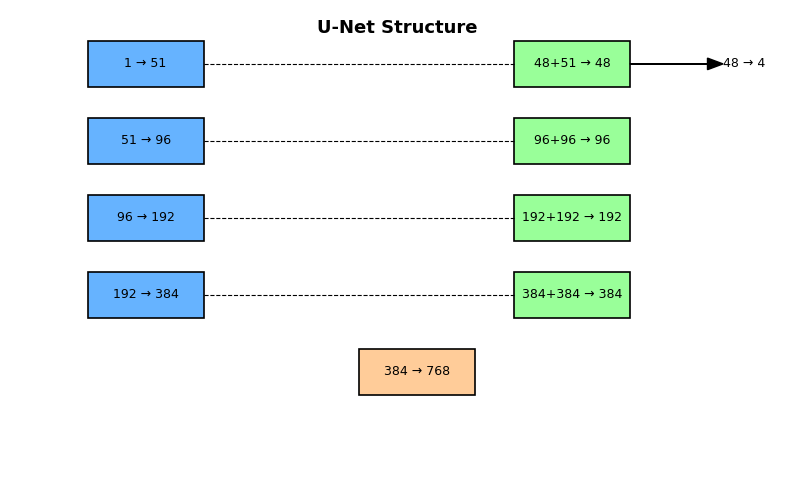

💾 Saved pruned model to /media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/pruned/pruned_model.pth
✅ UNet successfully rebuilt.


In [5]:
pruned_model = rebuild_pruned_unet(
    model,
    masks, 
    save_path="/media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/pruned/pruned_model.pth")

In [6]:
post_ratios = compute_actual_prune_ratios(model, pruned_model)


In [7]:
df_pruned = model_to_dataframe_with_l1(
    pruned_model,
    remove_nan_layers=False,
    block_ratios=block_ratios,
    post_prune_ratios=post_ratios
)
display(df_pruned)

,Layer,Type,Shape,In Ch,Out Ch,Num Params,Mean L1,Min L1,Max L1,L1 Std,Block Ratio,Post-Prune Ratio
0,encoders.0,DoubleConv,None,NaN,NaN,24072,NaN,NaN,NaN,NaN,0.2,None
1,encoders.0.net.0,Conv2d,"(51, 1, 3, 3)",1.0,51.0,459,1.460514,0.876300,1.965458,0.256630,0.2,0.2031
2,encoders.0.net.1,BatchNorm2d,"(51,)",NaN,NaN,102,NaN,NaN,NaN,NaN,0.2,None
3,encoders.0.net.2,ReLU,None,NaN,NaN,0,NaN,NaN,NaN,NaN,0.2,None
4,encoders.0.net.3,Conv2d,"(51, 51, 3, 3)",51.0,51.0,23409,9.575738,9.071277,10.307580,0.234493,0.2,0.2031
5,encoders.0.net.4,BatchNorm2d,"(51,)",NaN,NaN,102,NaN,NaN,NaN,NaN,0.2,None
6,encoders.0.net.5,ReLU,None,NaN,NaN,0,NaN,NaN,NaN,NaN,0.2,None
7,encoders.1,DoubleConv,None,NaN,NaN,127392,NaN,NaN,NaN,NaN,0.25,None
8,encoders.1.net.0,Conv2d,"(96, 51, 3, 3)",51.0,96.0,44064,9.572503,8.728145,10.230670,0.280527,0.25,0.25
9,encoders.1.net.1,BatchNorm2d,"(96,)",NaN,NaN,192,NaN,NaN,NaN,NaN,0.25,None


In [8]:
evaluate()

🔍 Evaluating model from: /media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/pruned/pruned_model.pth
📂 Saving results to: results/UNet_ACDC/exp1/pruned/evaluation
✅ Loaded 3000 test batches.

🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=51
Encoder 2 : in=51   → out=96
Encoder 3 : in=96   → out=192
Encoder 4 : in=192  → out=384
Bottleneck : in=384  → out=768
Decoder 1 : skip=384  + up=768  → out=384
Decoder 2 : skip=192  + up=384  → out=192
Decoder 3 : skip=96   + up=192  → out=96
Decoder 4 : skip=51   + up=96   → out=51
Output conv: 51 → 4


🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=51
Encoder 2 : in=51   → out=96
Encoder 3 : in=96   → out=192
Encoder 4 : in=192  → out=384
Bottleneck : in=384  → out=768
Decoder 1 : skip=384  + up=768  → out=384
Decoder 2 : skip=192  + up=384  → out=192
Decoder 3 : skip=96   + up=192  → out=96
Decoder 4 : skip=51   + up=96   → out=48
Output conv: 48 → 4

✅ Built pruned UNet | enc: [51, 96, 19

Evaluating: 100%|██████████| 3000/3000 [00:30<00:00, 99.14it/s] 


✅ Evaluation complete!
📊 Mean Dice: 0.1998
📊 Mean IoU:  0.1872
───────────────────────────────
Background    Dice=0.0000  IoU=0.0000
RV            Dice=0.5763  IoU=0.5763
Myocardium    Dice=0.1100  IoU=0.1100
LV            Dice=0.1128  IoU=0.0626
───────────────────────────────
💾 Metrics saved to results/UNet_ACDC/exp1/pruned/evaluation/eval_metrics.json
